In [146]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [147]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (139,140,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [148]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [149]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [150]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with zero or negative fare') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']<20]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with fare greater than $20') 

# exclude problematic data
old_len = len(df)
df = df[df['HH_0Veh']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with negative 0 veh HH') 


Excluding 3 records with missing VRM
Excluding 108 records with zero or negative fare
Excluding 66 records with fare greater than $20
Excluding 27 records with negative 0 veh HH


In [151]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 



Excluding 28 records with discontinuities in year.
Excluding 23 records with discontinuities in year.
Excluding 19 records with discontinuities in year.
Excluding 14 records with discontinuities in year.
Excluding 9 records with discontinuities in year.
Excluding 8 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 3 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [152]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [153]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [154]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])


In [155]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [156]:
# test rail ramp up period
df['YEARS_SINCE_RAIL_START'] = (df['Year'] - df['min_year']) * df['RAIL_FLAG']
df['YEARS_SINCE_RAIL_START'] = np.where(df['min_year']==2002, 0, df['YEARS_SINCE_RAIL_START'])

df['YEARS_SINCE_RAIL_START_1'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 1))
df['YEARS_SINCE_RAIL_START_2'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_RAIL_START_3'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 3))



In [157]:
df.to_csv('temp.csv')

In [158]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [159]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].astype(float)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].astype(float)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].astype(float)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].astype(float)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].astype(float)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].astype(float)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].astype(float)


In [160]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [161]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [162]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [163]:
df.to_csv('temp.csv')

## Some core model specification tests -- looking at traditional factors

In [164]:
# no time trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4809
Estimator:                   PanelOLS   R-squared (Between):              0.9903
No. Observations:                3983   R-squared (Within):               0.4809
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9900
Time:                        14:59:40   Log-likelihood                    1236.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      573.89
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(6,3717)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             573.89
                            

In [165]:
# with inflation adjusted prices

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4781
Estimator:                   PanelOLS   R-squared (Between):              0.9930
No. Observations:                3983   R-squared (Within):               0.4781
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9927
Time:                        14:59:40   Log-likelihood                    1225.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      567.60
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(6,3717)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             567.60
                            

In [166]:
# separate pop and emp


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + Tot_Pop_log \
                    + TOT_EMP_MSA_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4821
Estimator:                   PanelOLS   R-squared (Between):              0.9593
No. Observations:                3983   R-squared (Within):               0.4821
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9588
Time:                        14:59:40   Log-likelihood                    1241.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      494.24
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(7,3716)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             494.24
                            

In [167]:
# add average speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + AVG_SPEED_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4871
Estimator:                   PanelOLS   R-squared (Between):              0.9867
No. Observations:                3983   R-squared (Within):               0.4871
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9864
Time:                        14:59:41   Log-likelihood                    1260.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      504.22
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(7,3716)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             504.22
                            

In [168]:
# add average speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + AVG_SPEED \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4786
Estimator:                   PanelOLS   R-squared (Between):              0.9926
No. Observations:                3983   R-squared (Within):               0.4786
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9924
Time:                        14:59:41   Log-likelihood                    1227.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      487.23
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(7,3716)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             487.23
                            

In [169]:
# VRH and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRH_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4823
Estimator:                   PanelOLS   R-squared (Between):              0.9909
No. Observations:                3983   R-squared (Within):               0.4823
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9906
Time:                        14:59:42   Log-likelihood                    1241.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      494.48
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(7,3716)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             494.48
                            

In [170]:
# VRH and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRH_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.3600
Estimator:                   PanelOLS   R-squared (Between):              0.9714
No. Observations:                3983   R-squared (Within):               0.3600
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9707
Time:                        14:59:42   Log-likelihood                    819.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      348.43
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(6,3717)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             348.43
                            

## look at lagging the VRM and the Fares

In [171]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4781
Estimator:                   PanelOLS   R-squared (Between):              0.9930
No. Observations:                3983   R-squared (Within):               0.4781
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9927
Time:                        14:59:42   Log-likelihood                    1225.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      567.60
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(6,3717)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             567.60
                            

In [172]:
# base model--LAG 1

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4796
Estimator:                   PanelOLS   R-squared (Between):              0.9949
No. Observations:                3981   R-squared (Within):               0.4796
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9947
Time:                        14:59:43   Log-likelihood                    1231.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      489.00
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(7,3714)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             489.00
                            

In [173]:
# base model--LAG 1 AND 2

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + VRM_ADJ_LAGGED_2_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4809
Estimator:                   PanelOLS   R-squared (Between):              0.9950
No. Observations:                3979   R-squared (Within):               0.4809
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9948
Time:                        14:59:43   Log-likelihood                    1235.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      429.80
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                  F(8,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             429.80
                            

In [174]:
# LAG FARES - 1

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4813
Estimator:                   PanelOLS   R-squared (Between):              0.9964
No. Observations:                3983   R-squared (Within):               0.4813
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9963
Time:                        14:59:43   Log-likelihood                    1237.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      492.62
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(7,3716)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             492.62
                            

In [175]:
# LAG FARES AND VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4841
Estimator:                   PanelOLS   R-squared (Between):              0.9945
No. Observations:                3981   R-squared (Within):               0.4841
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9943
Time:                        14:59:44   Log-likelihood                    1248.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      435.43
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(8,3713)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             435.43
                            

In [176]:
# Calculate service cuts versus gains
df['VRM_CUT'] =np.where(df['Bus_VRM_ADJ_diff']<0, 1, 0)
df['VRM_CUT'] =np.where(df['Rail_VRM_ADJ_diff']<0, 1, df['VRM_CUT'])

df['VRM_ADJ_CUT_log']  = df['VRM_ADJ_log'] * df['VRM_CUT']
df['VRM_ADJ_GAIN_log'] = df['VRM_ADJ_log'] * (1-df['VRM_CUT'])

df['VRM_ADJ_LAGGED_1_CUT_log']  = df['VRM_ADJ_LAGGED_1_log'] * df['VRM_CUT']
df['VRM_ADJ_LAGGED_1_GAIN_log'] = df['VRM_ADJ_LAGGED_1_log'] * (1-df['VRM_CUT'])

df['VRM_ADJ_LAGGED_2_CUT_log']  = df['VRM_ADJ_LAGGED_2_log'] * df['VRM_CUT']
df['VRM_ADJ_LAGGED_2_GAIN_log'] = df['VRM_ADJ_LAGGED_2_log'] * (1-df['VRM_CUT'])

# calculate fare increase versus decrease
df['FARE_INCREASE'] =np.where(df['FARE_per_UPT_2018']>0, 1, 0)

df['FARE_per_UPT_INCREASE_2018_log']  = df['FARE_per_UPT_2018_log'] * df['FARE_INCREASE']
df['FARE_per_UPT_DECREASE_2018_log']  = df['FARE_per_UPT_2018_log'] * (1-df['FARE_INCREASE'])

df['FARE_per_UPT_INCREASE_2018_LAGGED_1_log']  = df['FARE_per_UPT_2018_LAGGED_1_log'] * df['FARE_INCREASE']
df['FARE_per_UPT_DECREASE_2018_LAGGED_1_log']  = df['FARE_per_UPT_2018_LAGGED_1_log'] * (1-df['FARE_INCREASE'])

df['FARE_per_UPT_INCREASE_2018_LAGGED_2_log']  = df['FARE_per_UPT_2018_LAGGED_2_log'] * df['FARE_INCREASE']
df['FARE_per_UPT_DECREASE_2018_LAGGED_2_log']  = df['FARE_per_UPT_2018_LAGGED_2_log'] * (1-df['FARE_INCREASE'])


In [177]:
# split VRM increase vs decrease

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_GAIN_log \
                    + VRM_ADJ_CUT_log \
                    + VRM_ADJ_LAGGED_1_GAIN_log \
                    + VRM_ADJ_LAGGED_1_CUT_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4909
Estimator:                   PanelOLS   R-squared (Between):              0.9973
No. Observations:                3981   R-squared (Within):               0.4909
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9972
Time:                        14:59:44   Log-likelihood                    1275.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      357.90
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                 F(10,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             357.90
                            

In [178]:
# split VRM increase vs decrease

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_GAIN_log \
                    + VRM_ADJ_CUT_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4827
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                3983   R-squared (Within):               0.4827
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9967
Time:                        14:59:45   Log-likelihood                    1243.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      433.29
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(8,3715)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             433.29
                            

In [179]:
# split VRM increase vs decrease

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_GAIN_log \
                    + VRM_ADJ_LAGGED_1_CUT_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4850
Estimator:                   PanelOLS   R-squared (Between):              0.9954
No. Observations:                3981   R-squared (Within):               0.4850
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9953
Time:                        14:59:45   Log-likelihood                    1252.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      388.49
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             388.49
                            

In [180]:
# split VRM increase vs decrease

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_GAIN_log \
                    + VRM_ADJ_LAGGED_1_CUT_log \
                    + VRM_ADJ_LAGGED_2_GAIN_log \
                    + VRM_ADJ_LAGGED_2_CUT_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4865
Estimator:                   PanelOLS   R-squared (Between):              0.9957
No. Observations:                3979   R-squared (Within):               0.4865
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9956
Time:                        14:59:45   Log-likelihood                    1257.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      319.39
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(11,3708)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             319.39
                            

In [181]:
# SPLIT FARE INCREASE VS DECREASE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_INCREASE_2018_log \
                    + FARE_per_UPT_DECREASE_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

In [182]:
# split lag on fares

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_INCREASE_2018_LAGGED_1_log \
                    + FARE_per_UPT_DECREASE_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

## Look at demographics

In [183]:
# new base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4841
Estimator:                   PanelOLS   R-squared (Between):              0.9945
No. Observations:                3981   R-squared (Within):               0.4841
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9943
Time:                        14:59:49   Log-likelihood                    1248.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      435.43
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(8,3713)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             435.43
                            

In [184]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_U35 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4842
Estimator:                   PanelOLS   R-squared (Between):              0.9973
No. Observations:                3981   R-squared (Within):               0.4842
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9972
Time:                        14:59:49   Log-likelihood                    1249.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      387.23
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             387.23
                            

In [185]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_100P \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4858
Estimator:                   PanelOLS   R-squared (Between):              0.9975
No. Observations:                3981   R-squared (Within):               0.4858
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9977
Time:                        14:59:50   Log-likelihood                    1255.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      389.62
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             389.62
                            

In [186]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_U35 \
                    + INC_100P \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4863
Estimator:                   PanelOLS   R-squared (Between):              0.9980
No. Observations:                3981   R-squared (Within):               0.4863
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9981
Time:                        14:59:50   Log-likelihood                    1257.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      351.33
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                 F(10,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             351.33
                            

In [187]:
# median income


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MED_INC_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4844
Estimator:                   PanelOLS   R-squared (Between):              0.9948
No. Observations:                3981   R-squared (Within):               0.4844
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9947
Time:                        14:59:50   Log-likelihood                    1250.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      387.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             387.45
                            

In [188]:
# median income -- log


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MED_INC_2018_log \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4844
Estimator:                   PanelOLS   R-squared (Between):              0.9862
No. Observations:                3981   R-squared (Within):               0.4844
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9858
Time:                        14:59:51   Log-likelihood                    1250.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      387.51
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             387.51
                            

In [189]:
# mean income


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MEAN_INC_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4880
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                3981   R-squared (Within):               0.4880
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9968
Time:                        14:59:51   Log-likelihood                    1264.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      393.12
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             393.12
                            

In [190]:
# mean income - log


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MEAN_INC_2018_log \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4885
Estimator:                   PanelOLS   R-squared (Between):              0.9342
No. Observations:                3981   R-squared (Within):               0.4885
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9340
Time:                        14:59:52   Log-likelihood                    1265.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      393.84
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             393.84
                            

In [191]:
# median personal income

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TOTAL_MED_INC_INDIV_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4881
Estimator:                   PanelOLS   R-squared (Between):              0.9875
No. Observations:                3981   R-squared (Within):               0.4881
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9872
Time:                        14:59:52   Log-likelihood                    1264.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      393.21
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             393.21
                            

In [192]:
# median personal income - log

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4900
Estimator:                   PanelOLS   R-squared (Between):              0.8888
No. Observations:                3981   R-squared (Within):               0.4900
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.8888
Time:                        14:59:52   Log-likelihood                    1271.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      396.22
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                  F(9,3712)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             396.22
                            

In [193]:
# immigrant population

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4913
Estimator:                   PanelOLS   R-squared (Between):              0.9026
No. Observations:                3981   R-squared (Within):               0.4913
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9024
Time:                        14:59:53   Log-likelihood                    1276.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      358.35
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                 F(10,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             358.35
                            

In [194]:
# immigrant population - log

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4928
Estimator:                   PanelOLS   R-squared (Between):              0.9321
No. Observations:                3937   R-squared (Within):               0.4928
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9319
Time:                        14:59:53   Log-likelihood                    1351.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      356.34
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.142   Distribution:                 F(10,3667)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             356.34
                            

In [195]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4905
Estimator:                   PanelOLS   R-squared (Between):              0.8795
No. Observations:                3981   R-squared (Within):               0.4905
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.8795
Time:                        14:59:54   Log-likelihood                    1274.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      357.30
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                 F(10,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             357.30
                            

## bus vs rail competion

In [196]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4905
Estimator:                   PanelOLS   R-squared (Between):              0.8795
No. Observations:                3981   R-squared (Within):               0.4905
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.8795
Time:                        14:59:54   Log-likelihood                    1274.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      357.30
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.312   Distribution:                 F(10,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             357.30
                            

In [197]:
# include VRM on competing modes

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_COMPETING_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4927
Estimator:                   PanelOLS   R-squared (Between):              0.7806
No. Observations:                1120   R-squared (Within):               0.4927
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7803
Time:                        14:59:54   Log-likelihood                    655.63
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      90.774
Entities:                          81   P-value                           0.0000
Avg Obs:                       13.827   Distribution:                 F(11,1028)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             90.774
                            

In [198]:
# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS_log']  = df['VRM_ADJ_COMPETING_log'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL_log'] = df['VRM_ADJ_COMPETING_log'] * df['BUS_FLAG']


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_COMPETING_BUS_log \
                    + VRM_ADJ_COMPETING_RAIL_log \
                    + VRM_ADJ_LAGGED_1_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_2018_LAGGED_1_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4970
Estimator:                   PanelOLS   R-squared (Between):              0.7376
No. Observations:                1120   R-squared (Within):               0.4970
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7393
Time:                        14:59:55   Log-likelihood                    660.39
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      84.569
Entities:                          81   P-value                           0.0000
Avg Obs:                       13.827   Distribution:                 F(12,1027)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             84.569
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [199]:
# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS_log']  = df['VRM_ADJ_COMPETING_log'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL_log'] = df['VRM_ADJ_COMPETING_log'] * df['BUS_FLAG']


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRM_ADJ_COMPETING_BUS_log \
                    + VRM_ADJ_COMPETING_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4832
Estimator:                   PanelOLS   R-squared (Between):              0.6526
No. Observations:                1121   R-squared (Within):               0.4832
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6552
Time:                        14:59:55   Log-likelihood                    642.90
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      96.313
Entities:                          81   P-value                           0.0000
Avg Obs:                       13.840   Distribution:                 F(10,1030)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             96.313
                            

In [200]:
# flag testing introduction of new rail
df['RAIL_COMPETITION'] = np.where(df['VRM_ADJ_COMPETING']>0, 1, 0) * df['BUS_FLAG']


In [201]:
# competition flag with rail

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + RAIL_COMPETITION \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4866
Estimator:                   PanelOLS   R-squared (Between):              0.8697
No. Observations:                3983   R-squared (Within):               0.4866
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.8696
Time:                        14:59:56   Log-likelihood                    1258.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      391.16
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                  F(9,3714)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             391.16
                            

In [202]:
# test competing fare

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + RAIL_COMPETITION \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4856
Estimator:                   PanelOLS   R-squared (Between):              0.6849
No. Observations:                1109   R-squared (Within):               0.4856
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6857
Time:                        14:59:57   Log-likelihood                    635.22
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      96.284
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(10,1020)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             96.284
                            

In [203]:
# test rail ramp up period

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4977
Estimator:                   PanelOLS   R-squared (Between):              0.6665
No. Observations:                1109   R-squared (Within):               0.4977
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6662
Time:                        14:59:57   Log-likelihood                    648.45
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      91.793
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(11,1019)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             91.793
                            

In [204]:
# test rail ramp up period

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_2 \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4915
Estimator:                   PanelOLS   R-squared (Between):              0.6599
No. Observations:                1109   R-squared (Within):               0.4915
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6602
Time:                        14:59:58   Log-likelihood                    641.67
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      89.551
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(11,1019)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             89.551
                            

In [205]:
# test rail ramp up period

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_3 \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4887
Estimator:                   PanelOLS   R-squared (Between):              0.6596
No. Observations:                1109   R-squared (Within):               0.4887
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6600
Time:                        14:59:59   Log-likelihood                    638.55
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      88.531
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(11,1019)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             88.531
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


## TNCs

In [206]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4977
Estimator:                   PanelOLS   R-squared (Between):              0.6665
No. Observations:                1109   R-squared (Within):               0.4977
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6662
Time:                        15:00:00   Log-likelihood                    648.45
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      91.793
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(11,1019)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             91.793
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [207]:
# add TNC flag

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5014
Estimator:                   PanelOLS   R-squared (Between):              0.6890
No. Observations:                1109   R-squared (Within):               0.5014
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6883
Time:                        15:00:01   Log-likelihood                    652.54
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      78.672
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(13,1017)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             78.672
                            

In [208]:
# add TNC per year

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5094
Estimator:                   PanelOLS   R-squared (Between):              0.7902
No. Observations:                1109   R-squared (Within):               0.5094
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7887
Time:                        15:00:02   Log-likelihood                    661.45
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      81.213
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(13,1017)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             81.213
                            

In [209]:
# TNC lags -- bus vs rail
df['TNC_FLAG_BUS_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['BUS_FLAG']

df['TNC_FLAG_RAIL_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['RAIL_FLAG']

In [210]:
# lagged TNC Effect


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_BUS_LAGGED_1 \
                    + TNC_FLAG_RAIL \
                    + TNC_FLAG_RAIL_LAGGED_1 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5027
Estimator:                   PanelOLS   R-squared (Between):              0.6889
No. Observations:                1109   R-squared (Within):               0.5027
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6882
Time:                        15:00:03   Log-likelihood                    654.04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      68.415
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(15,1015)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             68.415
                            

In [211]:
# lagged TNC Effect


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_BUS_LAGGED_1 \
                    + TNC_FLAG_BUS_LAGGED_2 \
                    + TNC_FLAG_RAIL \
                    + TNC_FLAG_RAIL_LAGGED_1 \
                    + TNC_FLAG_RAIL_LAGGED_2 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5042
Estimator:                   PanelOLS   R-squared (Between):              0.7155
No. Observations:                1109   R-squared (Within):               0.5042
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7145
Time:                        15:00:04   Log-likelihood                    655.66
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      60.598
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(17,1013)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             60.598
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [212]:
# lagged TNC Effect


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_BUS_LAGGED_1 \
                    + TNC_FLAG_BUS_LAGGED_2 \
                    + TNC_FLAG_BUS_LAGGED_3 \
                    + TNC_FLAG_RAIL \
                    + TNC_FLAG_RAIL_LAGGED_1 \
                    + TNC_FLAG_RAIL_LAGGED_2 \
                    + TNC_FLAG_RAIL_LAGGED_3 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5057
Estimator:                   PanelOLS   R-squared (Between):              0.7305
No. Observations:                1109   R-squared (Within):               0.5057
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7294
Time:                        15:00:05   Log-likelihood                    657.30
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      54.430
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(19,1011)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             54.430
                            

In [213]:
# Test TNC ramp up

df['YEARS_SINCE_TNC_BUS_2'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_BUS_3'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_BUS_4'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_BUS_5'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 5))

df['YEARS_SINCE_TNC_RAIL_2'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_RAIL_3'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_RAIL_4'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_RAIL_5'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 5))

In [214]:
# TNC ramp up

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS_2 \
                    + YEARS_SINCE_TNC_RAIL_2 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5050
Estimator:                   PanelOLS   R-squared (Between):              0.6973
No. Observations:                1109   R-squared (Within):               0.5050
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.6964
Time:                        15:00:06   Log-likelihood                    656.55
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      79.809
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(13,1017)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             79.809
                            

In [215]:
# TNC ramp up

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS_3 \
                    + YEARS_SINCE_TNC_RAIL_3 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5067
Estimator:                   PanelOLS   R-squared (Between):              0.7277
No. Observations:                1109   R-squared (Within):               0.5067
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7266
Time:                        15:00:07   Log-likelihood                    658.44
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      80.351
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(13,1017)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             80.351
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [216]:
# TNC ramp up

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS_4 \
                    + YEARS_SINCE_TNC_RAIL_4 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5082
Estimator:                   PanelOLS   R-squared (Between):              0.7599
No. Observations:                1109   R-squared (Within):               0.5082
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7586
Time:                        15:00:08   Log-likelihood                    660.17
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      80.846
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(13,1017)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             80.846
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [217]:
# TNC ramp up

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + FARE_per_UPT_COMPETING \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS_5 \
                    + YEARS_SINCE_TNC_RAIL_5 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5092
Estimator:                   PanelOLS   R-squared (Between):              0.7698
No. Observations:                1109   R-squared (Within):               0.5092
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.7684
Time:                        15:00:08   Log-likelihood                    661.32
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      81.175
Entities:                          79   P-value                           0.0000
Avg Obs:                       14.038   Distribution:                 F(13,1017)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             81.175
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


## Bike share and scooter

In [218]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4948
Estimator:                   PanelOLS   R-squared (Between):              0.9446
No. Observations:                3983   R-squared (Within):               0.4948
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9442
Time:                        15:00:10   Log-likelihood                    1290.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      302.87
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(12,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             302.87
                            

In [219]:
# add BIKE SHARE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4949
Estimator:                   PanelOLS   R-squared (Between):              0.9437
No. Observations:                3983   R-squared (Within):               0.4949
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9433
Time:                        15:00:10   Log-likelihood                    1290.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      259.56
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             259.56
                            

In [220]:
# add SCOOTERS

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4954
Estimator:                   PanelOLS   R-squared (Between):              0.9469
No. Observations:                3983   R-squared (Within):               0.4954
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9465
Time:                        15:00:11   Log-likelihood                    1292.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(16,3707)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.45
                            

In [221]:
# add dock count

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + dockCt_BUS \
                    + dockCt_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4960
Estimator:                   PanelOLS   R-squared (Between):              0.9516
No. Observations:                3983   R-squared (Within):               0.4960
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9512
Time:                        15:00:11   Log-likelihood                    1295.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      228.04
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(16,3707)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             228.04
                            

In [222]:
# current favorite

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4954
Estimator:                   PanelOLS   R-squared (Between):              0.9469
No. Observations:                3983   R-squared (Within):               0.4954
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9465
Time:                        15:00:12   Log-likelihood                    1292.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(16,3707)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.45
                            

In [223]:
# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4949
Estimator:                   PanelOLS   R-squared (Between):              0.9451
No. Observations:                3983   R-squared (Within):               0.4949
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9447
Time:                        15:00:12   Log-likelihood                    1290.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      242.24
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(15,3708)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             242.24
                            

In [224]:
# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4951
Estimator:                   PanelOLS   R-squared (Between):              0.9461
No. Observations:                3983   R-squared (Within):               0.4951
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9456
Time:                        15:00:13   Log-likelihood                    1291.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      242.36
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(15,3708)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             242.36
                            

In [225]:
# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4933
Estimator:                   PanelOLS   R-squared (Between):              0.9484
No. Observations:                3983   R-squared (Within):               0.4933
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9481
Time:                        15:00:13   Log-likelihood                    1284.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      277.86
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             277.86
                            

In [226]:
# exclude NY and see
df2 = df[df['CLUSTER_GT_NEW_11']!=100]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4955
Estimator:                   PanelOLS   R-squared (Between):              0.9500
No. Observations:                3949   R-squared (Within):               0.4955
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9496
Time:                        15:00:13   Log-likelihood                    1268.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      240.72
Entities:                         258   P-value                           0.0000
Avg Obs:                       15.306   Distribution:                 F(15,3676)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             240.72
                            

In [227]:
# merge bike and scooter for bus
df['BIKE_SCOOTER_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] + df['scooter_flag_BUS']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SCOOTER_SCOOTER_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4950
Estimator:                   PanelOLS   R-squared (Between):              0.9461
No. Observations:                3983   R-squared (Within):               0.4950
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9456
Time:                        15:00:14   Log-likelihood                    1290.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      259.63
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             259.63
                            

In [228]:
# merge bike and scooter for bus
df['BIKE_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SCOOTER_BUS \
                    + BIKE_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4948
Estimator:                   PanelOLS   R-squared (Between):              0.9447
No. Observations:                3983   R-squared (Within):               0.4948
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9443
Time:                        15:00:15   Log-likelihood                    1290.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      259.51
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             259.51
                            

In [229]:
# scooters only 

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4953
Estimator:                   PanelOLS   R-squared (Between):              0.9478
No. Observations:                3983   R-squared (Within):               0.4953
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9474
Time:                        15:00:15   Log-likelihood                    1292.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.00
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.00
                            

In [230]:
# scooter or bike
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_OR_SCOOTER_BUS'].apply(lambda x : min(x, 1))

df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 
df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_OR_SCOOTER_RAIL'].apply(lambda x : min(x, 1))

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_OR_SCOOTER_BUS \
                    + BIKE_OR_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4949
Estimator:                   PanelOLS   R-squared (Between):              0.9440
No. Observations:                3983   R-squared (Within):               0.4949
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9436
Time:                        15:00:16   Log-likelihood                    1290.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      259.55
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             259.55
                            

In [231]:
# BIKE SHARE ~ SCOOTERS
mod=PanelOLS.from_formula('BIKE_SHARE \
                    ~ scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]


                          PanelOLS Estimation Summary                           
Dep. Variable:             BIKE_SHARE   R-squared:                        0.0692
Estimator:                   PanelOLS   R-squared (Between):              0.0980
No. Observations:                4226   R-squared (Within):               0.0692
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.0795
Time:                        15:00:16   Log-likelihood                   -585.86
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      293.88
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.367   Distribution:                  F(1,3950)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             293.88
                            

## Maintenance and restructures

In [232]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4948
Estimator:                   PanelOLS   R-squared (Between):              0.9446
No. Observations:                3983   R-squared (Within):               0.4948
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9442
Time:                        15:00:20   Log-likelihood                    1290.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      302.87
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(12,3711)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             302.87
                            

In [233]:
# add bus restructures

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + RESTRUCTURE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4951
Estimator:                   PanelOLS   R-squared (Between):              0.9448
No. Observations:                3983   R-squared (Within):               0.4951
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9443
Time:                        15:00:21   Log-likelihood                    1291.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.85
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.85
                            

In [234]:
# add maintenance issues

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4950
Estimator:                   PanelOLS   R-squared (Between):              0.9444
No. Observations:                3983   R-squared (Within):               0.4950
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9439
Time:                        15:00:21   Log-likelihood                    1291.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.73
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.73
                            

In [235]:
# restructure and maintenance


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE \
                    + RESTRUCTURE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4953
Estimator:                   PanelOLS   R-squared (Between):              0.9445
No. Observations:                3983   R-squared (Within):               0.4953
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9441
Time:                        15:00:22   Log-likelihood                    1292.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.01
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.01
                            

In [236]:
# Split NYC from WMATA on maintenance
# NYC is prefectly correlated with something?

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + MAINTENANCE_NYC \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4955
Estimator:                   PanelOLS   R-squared (Between):              0.9446
No. Observations:                3983   R-squared (Within):               0.4955
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9442
Time:                        15:00:22   Log-likelihood                    1293.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.19
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.19
                            

In [237]:
# Maintenance with just WMATA

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4952
Estimator:                   PanelOLS   R-squared (Between):              0.9439
No. Observations:                3983   R-squared (Within):               0.4952
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9435
Time:                        15:00:23   Log-likelihood                    1292.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.99
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.99
                            

## Average auto ownership

In [238]:
# calculate average vehicles
df['AVG_VEHS'] = (df['HH_1Veh'] + 2*df['HH_2Veh'] + 3*df['HH_3Veh'] + 4*df['HH_4+Veh']) / (df['HH_0Veh'] + df['HH_1Veh'] + df['HH_2Veh'] + df['HH_3Veh'] + df['HH_4+Veh'])
df['AVG_VEHS_log'] = np.log(1+df['AVG_VEHS'])


In [239]:
# Maintenance with just WMATA

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4952
Estimator:                   PanelOLS   R-squared (Between):              0.9439
No. Observations:                3983   R-squared (Within):               0.4952
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9435
Time:                        15:00:26   Log-likelihood                    1292.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.99
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.99
                            

In [240]:
# replace 0 veh HH with average vehicles

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + AVG_VEHS \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4948
Estimator:                   PanelOLS   R-squared (Between):              0.9256
No. Observations:                3983   R-squared (Within):               0.4948
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9252
Time:                        15:00:27   Log-likelihood                    1290.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.49
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.49
                            

In [241]:
# replace 0 veh HH with average vehicles

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + AVG_VEHS_log \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4948
Estimator:                   PanelOLS   R-squared (Between):              0.9286
No. Observations:                3983   R-squared (Within):               0.4948
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9282
Time:                        15:00:27   Log-likelihood                    1290.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.45
                            

In [242]:
# 0 car and average cars

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + AVG_VEHS_log \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4958
Estimator:                   PanelOLS   R-squared (Between):              0.9454
No. Observations:                3983   R-squared (Within):               0.4958
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9449
Time:                        15:00:28   Log-likelihood                    1294.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.50
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.50
                            

## Aging population

In [243]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4952
Estimator:                   PanelOLS   R-squared (Between):              0.9439
No. Observations:                3983   R-squared (Within):               0.4952
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9435
Time:                        15:00:30   Log-likelihood                    1292.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.99
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.99
                            

In [244]:
# add old folks

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + Age_over64 \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4953
Estimator:                   PanelOLS   R-squared (Between):              0.9432
No. Observations:                3983   R-squared (Within):               0.4953
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9428
Time:                        15:00:31   Log-likelihood                    1292.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      259.97
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(14,3709)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             259.97
                            

In [245]:
# add old folks

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + Age_under18 \
                    + Age_over64 \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4957
Estimator:                   PanelOLS   R-squared (Between):              0.9508
No. Observations:                3983   R-squared (Within):               0.4957
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9503
Time:                        15:00:32   Log-likelihood                    1293.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      242.96
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(15,3708)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             242.96
                            

## Work at home and other JTW data

In [246]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4952
Estimator:                   PanelOLS   R-squared (Between):              0.9439
No. Observations:                3983   R-squared (Within):               0.4952
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9435
Time:                        15:00:36   Log-likelihood                    1292.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      279.99
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(13,3710)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             279.99
                            

In [247]:
# add work at home percent

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4960
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4960
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9485
Time:                        15:00:38   Log-likelihood                    1291.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(14,3705)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.45
                            

In [248]:
#  other commuting

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + JTW_OTHER_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)





C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4980
Estimator:                   PanelOLS   R-squared (Between):              0.9522
No. Observations:                3979   R-squared (Within):               0.4980
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9518
Time:                        15:01:54   Log-likelihood                    1299.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      244.93
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(15,3704)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             244.93
                            

In [250]:
# walk bike other commuting
df['JTW_WALK_BIKE_OTHER_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT'] + df['JTW_OTHER_PCT']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + JTW_WALK_BIKE_OTHER_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4971
Estimator:                   PanelOLS   R-squared (Between):              0.9581
No. Observations:                3979   R-squared (Within):               0.4971
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9577
Time:                        15:03:29   Log-likelihood                    1296.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      244.10
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(15,3704)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             244.10
                            

In [251]:
# walk bike commuting
df['JTW_WALK_BIKE_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + JTW_WALK_BIKE_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4961
Estimator:                   PanelOLS   R-squared (Between):              0.9517
No. Observations:                3979   R-squared (Within):               0.4961
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9513
Time:                        15:04:03   Log-likelihood                    1292.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      243.11
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(15,3704)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             243.11
                            

In [252]:
# preferred model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4960
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4960
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9485
Time:                        15:04:53   Log-likelihood                    1291.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(14,3705)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.45
                            

## Add back bike and scooter stuff

In [253]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4960
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4960
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9485
Time:                        15:05:32   Log-likelihood                    1291.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(14,3705)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.45
                            

In [254]:
# with bike and scooter

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)





C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4962
Estimator:                   PanelOLS   R-squared (Between):              0.9495
No. Observations:                3979   R-squared (Within):               0.4962
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9491
Time:                        15:06:16   Log-likelihood                    1292.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      214.47
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             214.47
                            

In [255]:
# with bike and scooter

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)





C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4964
Estimator:                   PanelOLS   R-squared (Between):              0.9505
No. Observations:                3979   R-squared (Within):               0.4964
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9501
Time:                        15:07:02   Log-likelihood                    1293.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      228.16
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             228.16
                            

In [256]:
# with bike and scooter

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)





C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4967
Estimator:                   PanelOLS   R-squared (Between):              0.9513
No. Observations:                3979   R-squared (Within):               0.4967
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9509
Time:                        15:08:00   Log-likelihood                    1294.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      202.88
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(18,3701)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             202.88
                            

## try time effects

In [257]:
# no time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4967
Estimator:                   PanelOLS   R-squared (Between):              0.9513
No. Observations:                3979   R-squared (Within):               0.4967
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9509
Time:                        15:09:21   Log-likelihood                    1294.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      202.88
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(18,3701)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             202.88
                            

In [258]:
# full time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    + TimeEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4232
Estimator:                   PanelOLS   R-squared (Between):              0.9739
No. Observations:                3979   R-squared (Within):               0.4864
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9735
Time:                        15:09:29   Log-likelihood                    1327.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      150.18
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(18,3685)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             150.18
                            

In [259]:
# trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + YEARS_SINCE_2002_BUS \
                    + YEARS_SINCE_2002_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5017
Estimator:                   PanelOLS   R-squared (Between):              0.9324
No. Observations:                3979   R-squared (Within):               0.5017
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9320
Time:                        15:10:25   Log-likelihood                    1314.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      186.20
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(20,3699)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             186.20
                            

In [260]:
# split trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + YEARS_2002_2014_BUS \
                    + YEARS_2002_2014_RAIL \
                    + YEARS_AFTER_2014_BUS \
                    + YEARS_AFTER_2014_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5069
Estimator:                   PanelOLS   R-squared (Between):              0.9583
No. Observations:                3979   R-squared (Within):               0.5069
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9578
Time:                        15:10:50   Log-likelihood                    1335.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      172.75
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(22,3697)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             172.75
                            

In [261]:
# it looks best without the time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4967
Estimator:                   PanelOLS   R-squared (Between):              0.9513
No. Observations:                3979   R-squared (Within):               0.4967
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9509
Time:                        15:14:15   Log-likelihood                    1294.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      202.88
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(18,3701)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             202.88
                            

## Test taking things out one at a time

In [268]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4967
Estimator:                   PanelOLS   R-squared (Between):              0.9513
No. Observations:                3979   R-squared (Within):               0.4967
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9509
Time:                        15:19:55   Log-likelihood                    1294.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      202.88
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(18,3701)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             202.88
                            

In [269]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4911
Estimator:                   PanelOLS   R-squared (Between):              0.9957
No. Observations:                3979   R-squared (Within):               0.4911
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9960
Time:                        15:20:20   Log-likelihood                    1272.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      210.14
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             210.14
                            

In [270]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4951
Estimator:                   PanelOLS   R-squared (Between):              0.9573
No. Observations:                3979   R-squared (Within):               0.4951
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9569
Time:                        15:20:38   Log-likelihood                    1288.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      213.50
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             213.50
                            

In [271]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4960
Estimator:                   PanelOLS   R-squared (Between):              0.9382
No. Observations:                3979   R-squared (Within):               0.4960
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9378
Time:                        15:21:34   Log-likelihood                    1292.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      214.35
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             214.35
                            

In [272]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5063
Estimator:                   PanelOLS   R-squared (Between):              0.9736
No. Observations:                4215   R-squared (Within):               0.5063
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9732
Time:                        15:21:42   Log-likelihood                    1313.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      236.68
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.327   Distribution:                 F(17,3923)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             236.68
                            

In [273]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4959
Estimator:                   PanelOLS   R-squared (Between):              0.9465
No. Observations:                3983   R-squared (Within):               0.4959
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9460
Time:                        15:21:53   Log-likelihood                    1294.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      214.42
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.319   Distribution:                 F(17,3706)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             214.42
                            

In [274]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4954
Estimator:                   PanelOLS   R-squared (Between):              0.9529
No. Observations:                3979   R-squared (Within):               0.4954
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9525
Time:                        15:22:02   Log-likelihood                    1289.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      213.82
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             213.82
                            

In [275]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4963
Estimator:                   PanelOLS   R-squared (Between):              0.9522
No. Observations:                3979   R-squared (Within):               0.4963
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9518
Time:                        15:22:13   Log-likelihood                    1292.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      214.53
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             214.53
                            

In [277]:
## Test taking things out one at a time--TNCs and BIKE_SHARE interact!

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4924
Estimator:                   PanelOLS   R-squared (Between):              0.9231
No. Observations:                3979   R-squared (Within):               0.4924
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9227
Time:                        15:23:24   Log-likelihood                    1277.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      224.54
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             224.54
                            

In [278]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4962
Estimator:                   PanelOLS   R-squared (Between):              0.9517
No. Observations:                3979   R-squared (Within):               0.4962
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9513
Time:                        15:23:32   Log-likelihood                    1292.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      214.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             214.45
                            

In [279]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4966
Estimator:                   PanelOLS   R-squared (Between):              0.9520
No. Observations:                3979   R-squared (Within):               0.4966
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9516
Time:                        15:24:37   Log-likelihood                    1294.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      228.28
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             228.28
                            

In [280]:
## Test taking things out one at a time

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4961
Estimator:                   PanelOLS   R-squared (Between):              0.9482
No. Observations:                3979   R-squared (Within):               0.4961
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9477
Time:                        15:24:47   Log-likelihood                    1292.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.86
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.86
                            

In [284]:
# just bike and scooters on bus, dropping rail

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4961
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4961
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9485
Time:                        15:31:05   Log-likelihood                    1292.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.89
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.89
                            

## Run some analytics

In [285]:

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4961
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4961
Date:                Thu, Dec 05 2019   R-squared (Overall):              0.9485
Time:                        15:31:53   Log-likelihood                    1292.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.89
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.89
                            

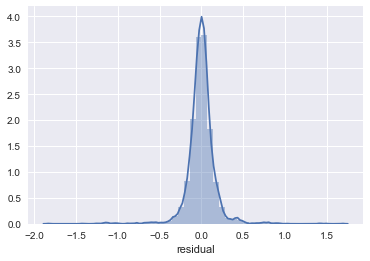

In [286]:
sns.distplot(res.resids)

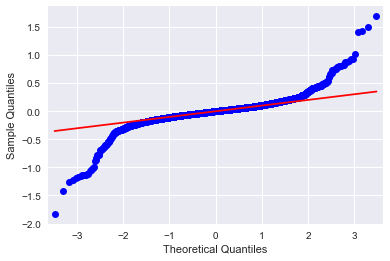

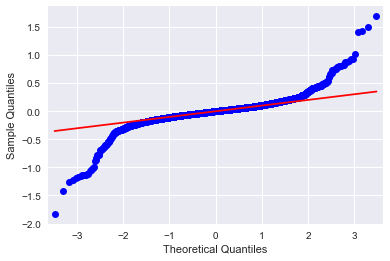

In [287]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [288]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [289]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
Akron, OH Metro Area-Bus 2002          0            24    15.469231   
                         2003          0            24    15.501150   
                         2004          0            24    15.591676   
                         2005          0            24    15.609548   
                         2006          0            24    15.619001   

                               VRM_ADJ_log  FARE_per_UPT_2018_log  \
Akron, OH Metro Area-Bus 2002    15.208377               0.568842   
                         2003    15.195930               1.362981   
                         2004    15.277699               1.247162   
                         2005    15.214971               1.355716   
                         2006    15.200501               1.356994   

                               POP_EMP_log  GAS_PRICE_2018_log  \
Akron, OH Metro Area-Bus 2002    13.808216            1.066089   
                         2003    13.823451            1.138954   
                         2004    13.839439            1.233697   
                         2005    13.857195            1.361617   
                         2006    13.879496            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  \
Akron, OH Metro Area-Bus 2002                     10.479210   
                         2003                     10.446267   
                         2004                     10.403980   
                         2005                     10.365663   
                         2006                     10.305856   

                               Tot_NonUSA_POP_pct  PCT_HH_NO_VEH  TSD_POP_PCT  \
Akron, OH Metro Area-Bus 2002           -0.060245           8.60     0.185260   
                         2003            0.114214           8.20     0.180770   
                         2004            0.288851           7.79     0.176377   
                         2005            0.430267           7.47     0.172435   
                         2006            0.669812           6.85     0.167543   

                               JTW_HOME_PCT  RAIL_COMPETITION  \
Akron, OH Metro Area-Bus 2002           3.1               0.0   
                         2003           3.1               0.0   
                         2004           3.1               0.0   
                         2005           3.1               0.0   
                         2006           2.5               0.0   

                               YEARS_SINCE_RAIL_START_1  YEARS_SINCE_TNC_BUS  \
Akron, OH Metro Area-Bus 2002                       0.0                  0.0   
                         2003                       0.0                  0.0   
                         2004                       0.0                  0.0   
                         2005                       0.0                  0.0   
                         2006                       0.0                  0.0   

                               YEARS_SINCE_TNC_RAIL  MAINTENANCE_WMATA  \
Akron, OH Metro Area-Bus 2002                   0.0                0.0   
                         2003                   0.0                0.0   
                         2004                   0.0                0.0   
                         2005                   0.0                0.0   
                         2006                   0.0                0.0   

                               BIKE_SHARE_BUS  scooter_flag_BUS   effects  \
Akron, OH Metro Area-Bus 2002             0.0               0.0  3.390014   
                         2003             0.0               0.0  3.390014   
                         2004             0.0               0.0  3.390014   
                         2005             0.0               0.0  3.390014   
                         2006             0.0               0.0  3.390014   

                               residual  
Akron, OH Metro Area-Bus 2002 -0.194166  
                         2003  0.028090  
                    

In [290]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [291]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

In [292]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0)

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'effects'] 
                                                    - app_data.loc[(id,base_year), 'effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])


In [293]:
# calculate the total change ratios

app_data['FAC_ratio'] = 1
for var in res.params.keys(): 
    app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data[var+'_FAC_ratio']
    
app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data['effects_FAC_ratio']

In [294]:
# calculate the FAC
app_data['Total_FAC'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['Total_FAC'] = app_data['Total_FAC'] + app_data[var+'_FAC']
app_data['effects_FAC'] = (app_data['effects_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
app_data['Total_FAC'] = app_data['Total_FAC'] + app_data['effects_FAC']

# scale the FAC
app_data['FAC_scale'] = app_data['fitted_exp_diff'] / app_data['Total_FAC']
app_data['FAC_scale'] = app_data['FAC_scale'].fillna(1)

app_data['Total_FAC_scaled'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC_scaled'] = app_data[var+'_FAC'] * app_data['FAC_scale']
    app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data[var+'_FAC_scaled']
app_data['effects_FAC_scaled'] = app_data[var+'_FAC_scaled'] * app_data['FAC_scale']
app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data['effects_FAC_scaled']


In [295]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [296]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [297]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['Total_FAC']
    
# scaled FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC_scaled']
out_fields = out_fields + ['Total_FAC_scaled']

# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [298]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['CLUSTER_APTA4', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
#    summary_data_gt[out_var] = summary_data_gt[out_var] / summary_data_gt['UPT_ADJ_base']
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_base']
#    summary_data_apta_hml[out_var] = summary_data_apta_hml[out_var] / summary_data_apta_hml['UPT_ADJ_base']
    

In [299]:
#summary_data_gt.to_csv('FAC_totals_GT_CLUSTERS.csv')
summary_data_apta4.to_csv('FAC_totals_APTA4_CLUSTERS.csv')
#summary_data_apta_hml.to_csv('FAC_totals_APTA_HML_CLUSTERS.csv')


In [300]:
summary_data_apta4.head(20)

CLUSTER_APTA  UPT_ADJ_base       UPT_ADJ  \
CLUSTER_APTA4 RAIL_FLAG Year                                             
1.0           0         2002           190  0.000000e+00  2.013179e+09   
                        2003           190  2.013179e+09  2.013821e+09   
                        2004           190  2.013821e+09  2.041333e+09   
                        2005           190  2.041333e+09  2.063005e+09   
                        2006           190  2.063005e+09  2.071799e+09   
                        2007           190  2.071799e+09  2.090532e+09   
                        2008           190  2.090532e+09  2.172421e+09   
                        2009           190  2.172421e+09  2.087737e+09   
                        2010           190  2.087737e+09  2.019401e+09   
                        2011           190  2.019401e+09  2.050938e+09   
                        2012           190  2.050938e+09  2.080704e+09   
                        2013           190  2.080704e+09  2.076741e+09   
                        2014           190  2.076741e+09  2.061719e+09   
                        2015           190  2.061719e+09  2.028750e+09   
                        2016           190  2.028750e+09  1.944705e+09   
                        2017           190  1.944705e+09  1.875434e+09   
                        2018           190  1.875434e+09  1.832288e+09   
              1         2002           140  0.000000e+00  1.217256e+09   
                        2003           140  1.217256e+09  1.210060e+09   
                        2004           160  1.210060e+09  1.282836e+09   

                              UPT_ADJ_diff    fitted_exp  fitted_exp_diff  \
CLUSTER_APTA4 RAIL_FLAG Year                                                
1.0           0         2002  0.000000e+00  1.849483e+09     0.000000e+00   
                        2003  6.425510e+05  1.973515e+09     1.240317e+08   
                        2004  2.751127e+07  2.024599e+09     5.108413e+07   
                        2005  2.167215e+07  2.068293e+09     4.369356e+07   
                        2006  8.794756e+06  2.134392e+09     6.609974e+07   
                        2007  1.873279e+07  2.162031e+09     2.763899e+07   
                        2008  8.188896e+07  2.240804e+09     7.877206e+07   
                        2009 -8.468456e+07  2.123291e+09    -1.175124e+08   
                        2010 -6.833532e+07  2.117659e+09    -5.632069e+06   
                        2011  3.153659e+07  2.150532e+09     3.287337e+07   
                        2012  2.976613e+07  2.121345e+09    -2.918780e+07   
                        2013 -3.963190e+06  2.078860e+09    -4.248460e+07   
                        2014 -1.502232e+07  2.040360e+09    -3.849984e+07   
                        2015 -3.296812e+07  1.929628e+09    -1.107317e+08   
                        2016 -8.404573e+07  1.855183e+09    -7.444524e+07   
                        2017 -6.927050e+07  1.852902e+09    -2.280839e+06   
                        2018 -4.314625e+07  1.819152e+09    -3.375036e+07   
              1         2002  0.000000e+00  1.133494e+09     0.000000e+00   
                        2003 -7.195719e+06  1.212420e+09     7.892621e+07   
                        2004  6.214108e+07  1.257248e+09     3.366901e+07   

                                   VRM_ADJ  FARE_per_UPT_2018       POP_EMP  \
CLUSTER_APTA4 RAIL_FLAG Year                                                  
1.0           0         2002           NaN                NaN           NaN   
                        2003  5.248391e+07           5.350668  7.061254e+06   
                        2004  5.326346e+07           5.466338  7.213577e+06   
                        2005  5.197083e+07           5.528897  7.409766e+06   
                        2006  5.206632e+07           5.485058  7.653103e+06   
                        2007  5.340645e+07           5.577975  7.706491e+06   
                        2008  5.411188e+07           5.445940  7.762979e+0